In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs

In [2]:
class GarmanKohlhagenModel:
    def __init__(
        self,
        spot: float,
        strike: float,
        time: float,
        r_domestic: float,
        r_foreign: float,
        vol: float,
    ):
        self.spot = spot
        self.strike = strike
        self.time = time
        self.r_domestic = r_domestic
        self.r_foreign = r_foreign
        self.vol = vol

    @property
    def _d1(self) -> float:
        return (
            np.log(self.spot / self.strike)
            + (self.r_domestic - self.r_foreign + 0.5 * self.vol**2) * self.time
        ) / (self.vol * np.sqrt(self.time))

    @property
    def _d2(self) -> float:
        return self._d1 - self.vol * np.sqrt(self.time)

    def call_price(self):
        return self.spot * np.exp(-self.r_foreign * self.time) * scs.norm.cdf(
            self._d1
        ) - self.strike * np.exp(-self.r_domestic * self.time) * scs.norm.cdf(self._d2)

    def put_price(self):
        return np.exp(-self.r_domestic * self.time) * self.strike * scs.norm.cdf(
            -self._d2
        ) - self.spot * np.exp(-self.r_foreign * self.time) * scs.norm.cdf(-self._d1)

In [3]:
# USDRUB pricing
NOTIONAL_USD = 1_000_000
CURRENT_SPOT = 90.0
STRIKE = 100.0
RATE_DOMESTIC = 15.0 / 100
RATE_FOREIGN = 5.0 / 100
VOL = 0.2
TIME = 1.0

In [4]:
usd_call = GarmanKohlhagenModel(
    spot=CURRENT_SPOT,
    strike=STRIKE,
    time=TIME,
    r_domestic=RATE_DOMESTIC,
    r_foreign=RATE_FOREIGN,
    vol=VOL,
)
# Premium in RUB
print(f"RUB premium: {usd_call.call_price() * NOTIONAL_USD: ,.2f}")

RUB premium:  6,610,073.67


Want premium in USD? There are two ways:
1. Convert directly by spot.
2. Price Put RUB Call USD.

1

In [5]:
# Convert directly by spot
print(f"USD premium: {usd_call.call_price() * NOTIONAL_USD / CURRENT_SPOT: ,.2f}")

USD premium:  73,445.26


2

In [6]:
notional_rub = NOTIONAL_USD * STRIKE
rub_put = GarmanKohlhagenModel(
    spot=1 / CURRENT_SPOT,
    strike=1 / STRIKE,
    time=TIME,
    r_domestic=RATE_FOREIGN,
    r_foreign=RATE_DOMESTIC,
    vol=VOL,
)
print(f"USD premium: {rub_put.put_price() * notional_rub: ,.2f}")

USD premium:  73,445.26


In [7]:
data = pd.read_pickle("../../../data/data.pkl")
data.head()

,bid,ask,rub_rate,usd_rate
timestamp,,,,
2017-01-03 07:00:00+00:00,60.973760,61.016500,8.126481,0.00672
2017-01-03 07:01:00+00:00,61.010855,61.068045,8.126481,0.00672
2017-01-03 07:02:00+00:00,61.037220,61.069850,8.126481,0.00672
2017-01-03 07:03:00+00:00,61.011955,61.048690,8.126481,0.00672
2017-01-03 07:04:00+00:00,61.021250,61.052835,8.126481,0.00672


In [8]:
usdrub = (data["bid"] + data["ask"]) / 2
usdrub.dropna(inplace=True)
usdrub

timestamp
2017-01-03 07:00:00+00:00    60.995130
2017-01-03 07:01:00+00:00    61.039450
2017-01-03 07:02:00+00:00    61.053535
2017-01-03 07:03:00+00:00    61.030322
2017-01-03 07:04:00+00:00    61.037042
                               ...    
2019-05-17 20:45:00+00:00    64.766768
2019-05-17 20:46:00+00:00    64.760530
2019-05-17 20:47:00+00:00    64.747895
2019-05-17 20:48:00+00:00    64.755327
2019-05-17 20:49:00+00:00    64.767623
Length: 494195, dtype: float64

In [9]:
rubusd = 1 / usdrub
rubusd

timestamp
2017-01-03 07:00:00+00:00    0.016395
2017-01-03 07:01:00+00:00    0.016383
2017-01-03 07:02:00+00:00    0.016379
2017-01-03 07:03:00+00:00    0.016385
2017-01-03 07:04:00+00:00    0.016383
                               ...   
2019-05-17 20:45:00+00:00    0.015440
2019-05-17 20:46:00+00:00    0.015442
2019-05-17 20:47:00+00:00    0.015445
2019-05-17 20:48:00+00:00    0.015443
2019-05-17 20:49:00+00:00    0.015440
Length: 494195, dtype: float64

In [10]:
(usdrub / usdrub.shift(1) - 1).std()

0.0002473561745126067

In [11]:
(rubusd / rubusd.shift(1) - 1).std()

0.00024733139550525804

<Axes: >

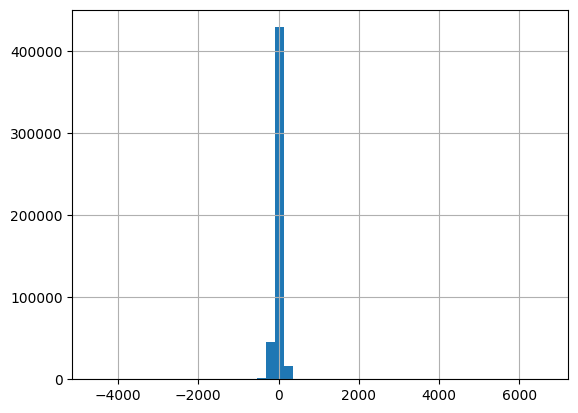

In [12]:
(252 * 60 * 24 * (usdrub / usdrub.shift(1) - 1)).hist(bins=50)

In [13]:
(usdrub / usdrub.shift(1) - 1).mean() * 252 * 60 * 24, (
    usdrub / usdrub.shift(1) - 1
).std() * np.sqrt(252 * 60 * 24)

(0.0551664443890885, 0.14900617694238114)

In [14]:
(rubusd / rubusd.shift(1) - 1).mean() * 252 * 60 * 24, (
    rubusd / rubusd.shift(1) - 1
).std() * np.sqrt(252 * 60 * 24)

(-0.03296601233961295, 0.14899125018682016)

In [15]:
(usdrub - usdrub.shift(1)).std() * np.sqrt(252 * 60 * 24), (
    rubusd - rubusd.shift(1)
).std() * np.sqrt(252 * 60 * 24)

(9.221129037513705, 0.002426101510274652)

In [16]:
usdrub.std()

3.897308008787486

In [17]:
x = pd.Series(
    np.exp(
        0.05 / 252 + np.random.normal(loc=0.0, scale=0.3, size=100_000) / 252
    ).cumprod()
)
(np.log(x / x.shift(1))).std()

0.0011915137354730693

In [18]:
y = 1 / x
(np.log(y / y.shift(1))).std()

0.0011915137354730695